<h1> <strong> Лабораторная работа 2

<h3> Суть - векторизовать контент статьи и кластеризовать данные

In [91]:
import sqlite3
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
import string
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Potron\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Potron\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [125]:
connection = sqlite3.connect('articles.db')
cursor = connection.cursor()

cursor.execute("""SELECT contents FROM articles LIMIT 231""")
articles = cursor.fetchall()

<h3> Подготовка

In [126]:
from natasha import (
    Segmenter,
    MorphVocab,

    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,

    PER,
    NamesExtractor,

    Doc
)

segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)

names_extractor = NamesExtractor(morph_vocab)

<h2> 1. Нормализация

<h3> Статья для векторизации

In [129]:
import nltk

article = articles[80] # вроде бы самая длинная статья

# Чиним статью. Сейчас каждая статья - это одна большая строка (str) с предложениями в кортежах. Получается список кортежей со статьями 
# Статью нужно разделить на предложения, которые будут отдельным элементом списка (т.е. [0 - первое предложение, 1 - второе предложение, ...])
# Если этого не сделать, то PCA не позволит сжать векторы до двух точек, из-за того, что, как я понял, в набор данных содержится всего лишь один объект (одна строка)
# Разбиение предложений на отдельные позиции списка позволит увеличить диапазон допустимых компонент (n_components)

articleForVectorize = list(article)

articleDividedIntoSentence = []

for i in articleForVectorize:
    sent = nltk.sent_tokenize(i, language="russian") # можно было бы при помощи split("."), но в статье есть название компании Electra.Aero. split считает эту точку как конец предложения
    for j in sent:
        articleDividedIntoSentence.append(j)

articleDividedIntoSentence

['Австралийский разработчик вертипортов Skyportz начинает расширение своей деятельности с запуском авиакомпании Wilbur Air, предлагающей грузовые и пассажирские перевозки.',
 'Вертипорт — это аэродром, предназначенный для вертикального взлёта и посадки воздушных судов, таких как вертолёты и вертикально взлетающие и садящиеся (VTOL) самолёты.',
 'Это системы,\xa0включающие в себя взлётно-посадочные площадки, терминалы для пассажиров, зоны обслуживания, а также инфраструктуру для зарядки и обслуживания электрических воздушных судов.',
 'Они играют большую роль в интеграции беспилотных воздушных транспортных систем и управлении воздушным пространством в условиях повышенной мобильности.',
 'Для компании Skyportz вертипорты являются ключевым компонентом их деятельности в области Advanced Air Mobility (AAM).',
 'Skyportz занимается разработкой, строительством и эксплуатацией вертипортов по всей Австралии.',
 'За последние пять лет Skyportz посвятила свою деятельность развитию вертипортов по 

<h3> Избавиться от пунктуации и прочего мусора

In [130]:
delete_punctuation = set(string.punctuation + '«»—' + string.digits + '\n' + '\xa0')
for i in articleDividedIntoSentence:
    cleaned_article = list(map(lambda x: ''.join(word for word in x if word not in delete_punctuation), articleDividedIntoSentence))


cleaned_article

['Австралийский разработчик вертипортов Skyportz начинает расширение своей деятельности с запуском авиакомпании Wilbur Air предлагающей грузовые и пассажирские перевозки',
 'Вертипорт  это аэродром предназначенный для вертикального взлёта и посадки воздушных судов таких как вертолёты и вертикально взлетающие и садящиеся VTOL самолёты',
 'Это системывключающие в себя взлётнопосадочные площадки терминалы для пассажиров зоны обслуживания а также инфраструктуру для зарядки и обслуживания электрических воздушных судов',
 'Они играют большую роль в интеграции беспилотных воздушных транспортных систем и управлении воздушным пространством в условиях повышенной мобильности',
 'Для компании Skyportz вертипорты являются ключевым компонентом их деятельности в области Advanced Air Mobility AAM',
 'Skyportz занимается разработкой строительством и эксплуатацией вертипортов по всей Австралии',
 'За последние пять лет Skyportz посвятила свою деятельность развитию вертипортов по всей Австралии и провела

<h3>Лемматизация

In [131]:
stop_words = set(stopwords.words('russian'))

def normalize_text(text):
    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    
    normalized_tokens = []
    for token in doc.tokens:
        token.lemmatize(morph_vocab)
        if token.lemma not in stop_words:
            normalized_tokens.append(token.lemma)
    return ' '.join(normalized_tokens)


normalized_article = [normalize_text(text) for text in cleaned_article]
normalized_article

['австралийский разработчик вертипорт skyportz начинать расширение свой деятельность запуск авиакомпания wilbur air предлагать грузовой пассажирский перевозка',
 'вертипорт это аэродром предназначить вертикальный взлет посадка воздушный судно вертолет вертикально взлетающие садиться vtol самолет',
 'это системывключать взлетнопосадочный площадка терминал пассажир зона обслуживание также инфраструктура зарядка обслуживание электрический воздушный судно',
 'играть больший роль интеграция беспилотный воздушный транспортный система управление воздушный пространство условие повышенный мобильность',
 'компания skyportz вертипорт являться ключевой компонент деятельность область advanced air mobility aam',
 'skyportz заниматься разработка строительство эксплуатация вертипорт весь австралия',
 'последний пять год skyportz посвятить свой деятельность развитие вертипорт весь австралия провести обширный исследование облегчение развитие инфраструктура aam международный уровень',
 'запуск wilbur air

<h2>2. Векторизация

In [132]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(normalized_article)
print("TF-IDF:")
print(vectorizer.get_feature_names_out())
print(X.toarray())

TF-IDF:
['aam' 'advanced' 'air' 'electra' 'electraaero' 'estol' 'mobility'
 'skyportz' 'vtol' 'wilbur' 'авиакомпания' 'авиаперевозчик'
 'австралийский' 'австралия' 'американский' 'ассортимент' 'аусман'
 'аэродром' 'беспилотный' 'больший' 'большинство' 'большой' 'бренд'
 'вертикально' 'вертикальный' 'вертипорт' 'вертолет' 'вертолетный' 'весь'
 'взлет' 'взлетающие' 'взлетнопосадочный' 'видеть' 'вместо' 'внедрение'
 'воздушный' 'выбрать' 'высокий' 'генеральный' 'география' 'год'
 'городской' 'грузовой' 'дальность' 'деятельность' 'директор' 'доступ'
 'доступность' 'дочерний' 'заинтересованный' 'заниматься' 'запуск'
 'зарядка' 'заявить' 'зона' 'играть' 'идеально' 'изначально' 'интеграция'
 'инфраструктура' 'использовать' 'исследование' 'качество' 'клем' 'клиент'
 'ключевой' 'компания' 'компонент' 'конечный' 'короткий' 'кроме' 'марк'
 'международный' 'метр' 'мобильность' 'мочь' 'направить' 'начинать' 'наш'
 'небольшой' 'низкий' 'новый' 'ньютонбраун' 'обеспечивать' 'обеспечить'
 'область' 'об

<h4>Count

<h2> 3. Сжатие векторов

In [133]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())
X_pca

array([[-0.29787926,  0.33979882],
       [ 0.48676575, -0.04488885],
       [ 0.301964  ,  0.15030057],
       [ 0.19488602,  0.46117677],
       [-0.30095462, -0.15349361],
       [-0.22493319, -0.33086977],
       [-0.27608647, -0.1299776 ],
       [-0.21693123,  0.3707879 ],
       [ 0.17912709,  0.532837  ],
       [-0.20447977,  0.06369994],
       [ 0.51643085, -0.20249829],
       [ 0.4924523 , -0.25399707],
       [ 0.22725169, -0.19185196],
       [-0.14533745, -0.19085607],
       [-0.40753395, -0.03992687],
       [-0.07428783,  0.12076392],
       [-0.29673156, -0.26448893],
       [ 0.04627763, -0.23651591]])

<h2>4. Кластеризация и результаты анализа

<h4>DBSCAN

In [134]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.2, min_samples=2) # 0.5 многовато для этой статьи, ибо всё захватывается в один кластер
clustersDBS = dbscan.fit_predict(X_pca) 
clustersDBS # предсказываем, в каком кластере окажется каждое предложение статьи

array([ 0,  1, -1,  2,  3,  3,  3,  0,  2,  4,  1,  1,  3,  3,  3,  4,  3,
        3], dtype=int64)

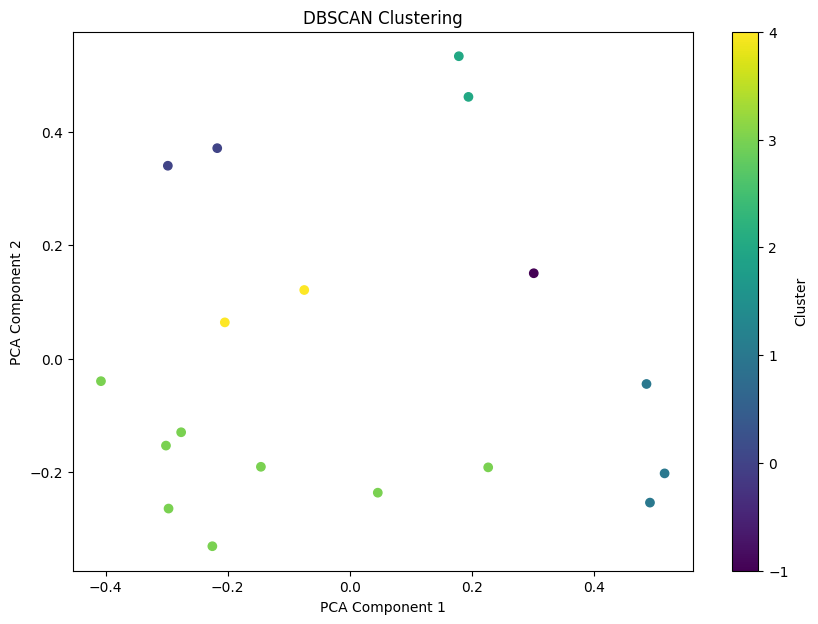

Cluster 0:
['Австралийский разработчик вертипортов Skyportz начинает расширение своей деятельности с запуском авиакомпании Wilbur Air предлагающей грузовые и пассажирские перевозки', 'С запуском Wilbur Air компания расширяет свою роль в качестве поставщика воздушной инфраструктуры для конечных пользователей и клиентов']
Cluster 1:
['Вертипорт  это аэродром предназначенный для вертикального взлёта и посадки воздушных судов таких как вертолёты и вертикально взлетающие и садящиеся VTOL самолёты', 'В отличие от большинства стартапов в области воздушного такси Skyportz выбрала электрические самолёты с коротким взлётом и посадкой eSTOL от ElectraAero вместо вертикального взлёта и посадки VTOL', 'Хотя для взлёта самолёты eSTOL требуют – метров взлётнопосадочной полосы в отличие от VTOL их низкие энергозатраты на взлёт позволяют им обеспечить больший дальность полёта на одной зарядке']
Cluster 2:
['Они играют большую роль в интеграции беспилотных воздушных транспортных систем и управлении возд

In [120]:
import pandas as pd

dfDBSCAN = pd.DataFrame({'x': X_pca[:, 0], 'y': X_pca[:, 1], 'cluster': clustersDBS})

plt.figure(figsize=(10, 7))
plt.scatter(dfDBSCAN['x'], dfDBSCAN['y'], c=dfDBSCAN['cluster'], cmap='viridis', marker='o')
plt.title('DBSCAN Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

for cluster in set(clustersDBS):
    print(f"Cluster {cluster}:")
    cluster_texts = [cleaned_article[i] for i in range(len(clustersDBS)) if clustersDBS[i] == cluster]
    print(cluster_texts)

<h2><strong>Анализ</strong><h2>

<h3> В результате кластеризации при помощи DBSCAN получилось 5 кластеров и 1 кластер с выбросами </h3>
<h5> В предложениях нулевого кластера говорится о запуске авиакомпании Wilbur Air</h5>
<h5> В предложениях первого кластера можно наблюдать терминологию и особенности самолётов eSTOL и VTOL </h5>
<h5> В предложениях второго кластера описывается информация о развитии воздушно-транспортных средств (очень натянутое утверждение)</h5>
<h5> В предложениях третьего кластера рассказывается про деятельность Skyportz и будущие планы развития Wilbur Air</h5>
<h5> В предложениях четвёртого кластера содержатся информация о том, что планирует делать компания Skyportz </h5>
<h5> В -1 кластере содержаться предложение-"выброс", т.е. его нельзя отнести к какому-либо кластеру, ничего общего у него с другими предложениями нет</h5>

<h2> Стало интересно узнать, как с этим справиться KMeans </h2>

<h4>KMeans

In [135]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 6) # ставим такое же кол-во кластеров, как и у DBSCAN
clustersKMeans = kmeans.fit_predict(X_pca)
clustersKMeans # предсказываем, в каком кластере окажется каждое предложение статьи

array([0, 4, 2, 5, 1, 1, 1, 0, 5, 3, 4, 4, 4, 1, 3, 3, 1, 1])

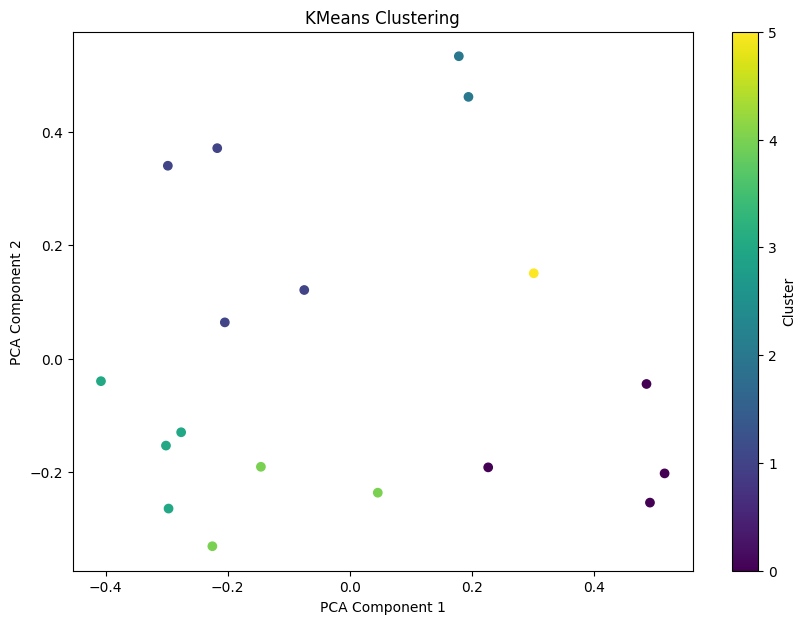

Cluster 0:
['Вертипорт  это аэродром предназначенный для вертикального взлёта и посадки воздушных судов таких как вертолёты и вертикально взлетающие и садящиеся VTOL самолёты', 'В отличие от большинства стартапов в области воздушного такси Skyportz выбрала электрические самолёты с коротким взлётом и посадкой eSTOL от ElectraAero вместо вертикального взлёта и посадки VTOL', 'Хотя для взлёта самолёты eSTOL требуют – метров взлётнопосадочной полосы в отличие от VTOL их низкие энергозатраты на взлёт позволяют им обеспечить больший дальность полёта на одной зарядке', 'Наш eSTOL идеально подходит для разнообразной географии Австралии он может использовать короткие взлётнопосадочные полосы как в городских так и в удалённых районах обеспечивая при этом высокую операционную эффективность']
Cluster 1:
['Австралийский разработчик вертипортов Skyportz начинает расширение своей деятельности с запуском авиакомпании Wilbur Air предлагающей грузовые и пассажирские перевозки', 'С запуском Wilbur Air ко

In [124]:
import pandas as pd

dfKMeans = pd.DataFrame({'x': X_pca[:, 0], 'y': X_pca[:, 1], 'cluster': clustersKMeans})

plt.figure(figsize=(10, 7))
plt.scatter(dfKMeans['x'], dfKMeans['y'], c=dfKMeans['cluster'], cmap='viridis', marker='o')
plt.title('KMeans Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

for cluster in set(clustersKMeans):
    print(f"Cluster {cluster}:")
    cluster_texts = [cleaned_article[i] for i in range(len(clustersKMeans)) if clustersKMeans[i] == cluster]
    print(cluster_texts)

<h2><strong>Анализ</strong></h2>

<h5> В предложениях нулевого кластера можно наблюдать терминологию и особенности самолётов eSTOL и VTOL </h5>
<h5> В предложениях первого кластера много информации об авиакомпании Wilbur Air, её запуске, роли, услугах </h5>
<h5> В предложениях второго кластера содержится информация о развитии воздушно-транспортных средств (очень натянутое утверждение) </h5>
<h5> В предложениях третьего кластера описывается, что " для компании Skyportz вертипорты являются ключевым компонентом их деятельности в области Advanced Air Mobility AAM " </h5>
<h5> В предложениях четвёртого кластера описывается деятельность различных компаний на материке Австралия </h5>
<h5> В пятый кластер попало всего лишь одно предложение </h5>

<h2><strong>Результаты анализа</strong><h2>

<h4> В результате кластеризации при помощи DBSCAN получилось 5 кластеров и один кластер с выбросами. Можно увидеть, что одно предложение нельзя отнести к какому-либо кластеру, поэтому оно является выбросом </h4>

<h4> В результате кластеризации при помощи KMeans при 6 кластерах можно увидеть, что кластер могут образовывать как одно предложение, так и четыре сразу </h4>

<h4> Некоторые темы кластеров при разных методах кластеризации имеют сходство между собой </h4>

<h4> В обоих случаях есть кластер, в котором оказалось всего лишь одно предложение, и это предложение для двух методов одно и тоже </h4>